In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import preprocess_input
import json
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
import tensorflow as tf

# Load the validation dataset
validation_set = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/plant-village-dataset-updated',
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),  # Adjusting the image size to match ResNet50 input
    shuffle=True,
    interpolation="bilinear",
    subset="validation",
    validation_split=0.2,  # Split data into training and validation
    seed=42 # Provide a seed for reproducibility
)



Found 67118 files belonging to 9 classes.
Using 13423 files for validation.


In [4]:
# Load the training dataset
training_set = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/plant-village-dataset-updated',
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),  # Adjusting the image size to match ResNet50 input
    shuffle=True,
    interpolation="bilinear",
    subset="training",
    validation_split=0.2,  # Split data into training and validation
    seed=42  # Provide a seed for reproducibility
)


Found 67118 files belonging to 9 classes.
Using 53695 files for training.


In [5]:
# Preprocess the datasets to match ResNet50 input requirements
training_set = training_set.map(lambda x, y: (preprocess_input(x), y))
validation_set = validation_set.map(lambda x, y: (preprocess_input(x), y))

In [6]:
# Load ResNet50 model without the top classification layer, using imagenet weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
# Freeze the base model layers to prevent them from being trained
base_model.trainable = False

In [8]:
# Build the new model on top of the ResNet50 base
model = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(9, activation='softmax')  # 38 classes in the dataset
])

In [9]:
from tensorflow.keras.metrics import Precision, Recall, AUC

# Compile the model with additional metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',           # Standard accuracy
        Precision(),          # Precision metric
        Recall(),             # Recall metric
        AUC(),                # AUC (Area Under Curve)
        'TruePositives',      # True positive count
        'TrueNegatives',      # True negative count
        'FalsePositives',     # False positive count
        'FalseNegatives'      # False negative count
    ]
)


In [10]:
# Model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           9,225 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,695,113 (98.02 MB)

 Trainable params: 2,107,401 (8.04 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [11]:
# Training the model
training_history = model.fit(
    x=training_set,
    validation_data=validation_set,
    epochs=10
)


Epoch 1/10
1678/1678 ━━━━━━━━━━━━━━━━━━━━ 185s 103ms/step - FalseNegatives: 2443.1738 - FalsePositives: 789.8076 - TrueNegatives: 214250.0312 - TruePositives: 24436.8066 - accuracy: 0.8932 - auc: 0.9845 - loss: 0.3472 - precision: 0.9474 - recall: 0.8467 - val_FalseNegatives: 115.0000 - val_FalsePositives: 85.0000 - val_TrueNegatives: 107299.0000 - val_TruePositives: 13308.0000 - val_accuracy: 0.9925 - val_auc: 1.0000 - val_loss: 0.0275 - val_precision: 0.9937 - val_recall: 0.9914
Epoch 2/10
1678/1678 ━━━━━━━━━━━━━━━━━━━━ 115s 68ms/step - FalseNegatives: 276.6123 - FalsePositives: 216.6510 - TrueNegatives: 214823.1875 - TruePositives: 26603.3672 - accuracy: 0.9907 - auc: 0.9998 - loss: 0.0344 - precision: 0.9918 - recall: 0.9894 - val_FalseNegatives: 81.0000 - val_FalsePositives: 70.0000 - val_TrueNegatives: 107314.0000 - val_TruePositives: 13342.0000 - val_accuracy: 0.9946 - val_auc: 0.9999 - val_loss: 0.0198 - val_precision: 0.9948 - val_recall: 0.9940
Epoch 3/10
1678/1678 ━━━━━━━━━━

In [12]:
# Evaluate the model on the training set

results = model.evaluate(training_set)

# Extracting loss and accuracy along with additional metrics
train_loss = results[0]
train_acc = results[1]
precision = results[2]
recall = results[3]
auc = results[4]
true_positives = results[5]
true_negatives = results[6]
false_positives = results[7]
false_negatives = results[8]

# Printing the results
print(f'Train Loss: {train_loss}, Train Accuracy: {train_acc}')
print(f'Precision: {precision}, Recall: {recall}, AUC: {auc}')
print(f'True Positives: {true_positives}, True Negatives: {true_negatives}')
print(f'False Positives: {false_positives}, False Negatives: {false_negatives}')

1678/1678 ━━━━━━━━━━━━━━━━━━━━ 94s 56ms/step - FalseNegatives: 26.4169 - FalsePositives: 26.4169 - TrueNegatives: 215013.4219 - TruePositives: 26853.5625 - accuracy: 0.9991 - auc: 1.0000 - loss: 0.0025 - precision: 0.9991 - recall: 0.9991
Train Loss: 0.0025832352694123983, Train Accuracy: 0.9990129470825195
Precision: 0.9990129470825195, Recall: 0.9990129470825195, AUC: 0.9999995827674866
True Positives: 53642.0, True Negatives: 429507.0
False Positives: 53.0, False Negatives: 53.0


In [13]:
# Evaluate the model on the validation set


results = model.evaluate(validation_set)

# Extracting loss and accuracy along with additional metrics
train_loss = results[0]
train_acc = results[1]
precision = results[2]
recall = results[3]
auc = results[4]
true_positives = results[5]
true_negatives = results[6]
false_positives = results[7]
false_negatives = results[8]

# Printing the results
print(f'Train Loss: {train_loss}, Train Accuracy: {train_acc}')
print(f'Precision: {precision}, Recall: {recall}, AUC: {auc}')
print(f'True Positives: {true_positives}, True Negatives: {true_negatives}')
print(f'False Positives: {false_positives}, False Negatives: {false_negatives}')

420/420 ━━━━━━━━━━━━━━━━━━━━ 23s 55ms/step - FalseNegatives: 27.5701 - FalsePositives: 27.5701 - TrueNegatives: 53987.1758 - TruePositives: 6724.2729 - accuracy: 0.9949 - auc: 0.9998 - loss: 0.0153 - precision: 0.9949 - recall: 0.9949
Train Loss: 0.012332986108958721, Train Accuracy: 0.9961260557174683
Precision: 0.9961260557174683, Recall: 0.9961260557174683, AUC: 0.999828577041626
True Positives: 13371.0, True Negatives: 107332.0
False Positives: 52.0, False Negatives: 52.0


In [14]:
# Load the test dataset from the 'Test' subdirectories of the plant categories
test_set = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/plant-village-dataset-updated',
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),  # Adjusting the image size to match ResNet50 input
    shuffle=False,  # Typically, you don't shuffle the test set
    interpolation="bilinear",
)

# Evaluate the model on the test set
test_results = model.evaluate(test_set)

# Extracting test metrics
test_loss = test_results[0]
test_acc = test_results[1]
test_precision = test_results[2]
test_recall = test_results[3]
test_auc = test_results[4]
test_true_positives = test_results[5]
test_true_negatives = test_results[6]
test_false_positives = test_results[7]
test_false_negatives = test_results[8]

# Printing the results for the test set
print(f'Test Loss: {test_loss}, Test Accuracy: {test_acc}')
print(f'Test Precision: {test_precision}, Test Recall: {test_recall}, Test AUC: {test_auc}')
print(f'Test True Positives: {test_true_positives}, Test True Negatives: {test_true_negatives}')
print(f'Test False Positives: {test_false_positives}, Test False Negatives: {test_false_negatives}')


Found 67118 files belonging to 9 classes.
2098/2098 ━━━━━━━━━━━━━━━━━━━━ 100s 47ms/step - FalseNegatives: 977.4469 - FalsePositives: 894.4845 - TrueNegatives: 267905.2500 - TruePositives: 32622.5215 - accuracy: 0.9676 - auc: 0.9971 - loss: 0.1128 - precision: 0.9691 - recall: 0.9666
Test Loss: 0.12825168669223785, Test Accuracy: 0.9649423360824585
Test Precision: 0.9669069051742554, Test Recall: 0.9633630514144897, Test AUC: 0.9962655305862427
Test True Positives: 64659.0, Test True Negatives: 534731.0
Test False Positives: 2213.0, Test False Negatives: 2459.0


In [15]:
# Save the model
model.save('plant-village_disease_model_resnet50.keras')

In [16]:
# Save training history to JSON
with open('plant-village_resnet50_hist_resnet50.json', 'w') as f:
    json.dump(training_history.history, f)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


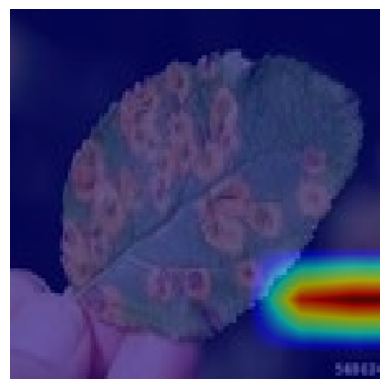

In [23]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

# Select an image to visualize (example from the validation set)
img_path = '/kaggle/input/apple-cedar-rust/apple cedar rust.jpeg'  # Replace with the path to an image from your dataset
img = image.load_img(img_path, target_size=(224, 224))  # Load the image with the target size
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = preprocess_input(img_array)  # Preprocess the image for ResNet50

# Get the model's prediction
preds = model.predict(img_array)
pred_class = np.argmax(preds[0])  # The predicted class (index)

# Get the last convolutional layer from the base model (ResNet50)
last_conv_layer = base_model.get_layer('conv5_block3_3_conv') 

# Create a model that outputs the activations of the last convolutional layer and the final predictions
grad_model = Model(
    inputs=[base_model.input],  # Use base_model.input instead of model.input
    outputs=[last_conv_layer.output, base_model.output]  # Use base_model.output here
)

# Compute the gradients of the top predicted class with respect to the output of the last convolutional layer
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(img_array)
    class_channel = predictions[:, pred_class]

# Compute the gradient of the class with respect to the feature map
grads = tape.gradient(class_channel, conv_outputs)

# Compute the mean intensity of the gradients for each feature map
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

# Convert conv_outputs to a NumPy array for manipulation
conv_outputs = conv_outputs[0].numpy()  # Convert the tensor to a NumPy array

# Multiply each feature map by the corresponding gradient value
for i in range(conv_outputs.shape[-1]):
    conv_outputs[:, :, i] *= pooled_grads[i].numpy()  # Use .numpy() to ensure the gradient is a NumPy array

# Compute the heatmap by averaging over all the channels
heatmap = np.mean(conv_outputs, axis=-1)

# Normalize the heatmap between 0 and 1
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

# Resize the heatmap to the size of the original image
heatmap = cv2.resize(heatmap, (img.size[0], img.size[1]))

# Create the final visualization
plt.imshow(img)
plt.imshow(heatmap, alpha=0.6, cmap='jet')  # Overlay heatmap on the original image
plt.axis('off')
plt.show()


In [18]:
for layer in base_model.layers:
    print(layer.name)


input_layer
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block1_add
conv3_block1_out
conv3_block2_1_conv
conv3_block2_1_bn
conv3_block2_1_relu
conv3_block2_2_conv
conv3_block2_2_bn
co